In [1]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import sys
%matplotlib inline

np.random.seed(0)
tf.set_random_seed(0)

In [2]:
# Load MNIST data in a format suited for tensorflow.
# The script input_data is available under this URL:
# https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/examples/tutorials/mnist/input_data.py
import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # haha
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

def batch_normalization(x,
                        mean,
                        variance,
                        offset,
                        scale,
                        variance_epsilon,
                        name=None):
  """Batch normalization.
  As described in http://arxiv.org/abs/1502.03167.
  Normalizes a tensor by `mean` and `variance`, and applies (optionally) a
  `scale` \\\\(\gamma\\\\) to it, as well as an `offset` \\\\(\\beta\\\\):
  \\\\(\\frac{\gamma(x-\mu)}{\sigma}+\\beta\\\\)
  `mean`, `variance`, `offset` and `scale` are all expected to be of one of two
  shapes:
    * In all generality, they can have the same number of dimensions as the
      input `x`, with identical sizes as `x` for the dimensions that are not
      normalized over (the 'depth' dimension(s)), and dimension 1 for the
      others which are being normalized over.
      `mean` and `variance` in this case would typically be the outputs of
      `tf.nn.moments(..., keep_dims=True)` during training, or running averages
      thereof during inference.
    * In the common case where the 'depth' dimension is the last dimension in
      the input tensor `x`, they may be one dimensional tensors of the same
      size as the 'depth' dimension.
      This is the case for example for the common `[batch, depth]` layout of
      fully-connected layers, and `[batch, height, width, depth]` for
      convolutions.
      `mean` and `variance` in this case would typically be the outputs of
      `tf.nn.moments(..., keep_dims=False)` during training, or running averages
      thereof during inference.
  Args:
    x: Input `Tensor` of arbitrary dimensionality.
    mean: A mean `Tensor`.
    variance: A variance `Tensor`.
    offset: An offset `Tensor`, often denoted \\\\(\\beta\\\\) in equations, or
      None. If present, will be added to the normalized tensor.
    scale: A scale `Tensor`, often denoted \\\\(\gamma\\\\) in equations, or
      `None`. If present, the scale is applied to the normalized tensor.
    variance_epsilon: A small float number to avoid dividing by 0.
    name: A name for this operation (optional).
  Returns:
    the normalized, scaled, offset tensor.
  """
  with tf.nn.ops.op_scope([x, mean, variance, scale, offset], name, "batchnorm"):
    inv = tf.nn.math_ops.rsqrt(variance + variance_epsilon)
    if scale is not None:
      inv *= scale
    return x * inv + (
        offset - mean * inv if offset is not None else -mean * inv)

In [14]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100, train_keep_prob=1.0, warmup=False, batch_norm = True, gen_distribution='bernoulli'):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        self.warmup = warmup
        self.batch_norm = batch_norm
        self.gen_distribution=gen_distribution
        self.train_keep_prob = train_keep_prob
        
        self.epoch = 0.
        self.beta = 1.
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Keep Probability
        self.keep_prob = tf.placeholder(tf.float32)
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()

        
        # Initializing the tensor flow variables
        init = tf.initialize_all_variables()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
        
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.mul(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

#         # Use generator to determine mean of
#         # Bernoulli distribution of reconstructed input
#         self.x_reconstr_mean = \
#             self._generator_network(network_weights["weights_gener"],
#                                     network_weights["biases_gener"])
            
            # Use generator to determine mean and (log) variance of
        # Gaussian distribution of reconstructed input
        self.x_reconstr_mean, self.x_reconstr_log_sigma_sq = \
            self._generator_network(network_weights["weights_gener"],
                                   network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_1 = tf.nn.dropout(layer_1, self.keep_prob)
        
        if self.batch_norm:
            mom_mean, mom_var = tf.nn.moments(layer_1, [0])
            layer_1 = batch_normalization(layer_1,mom_mean,mom_var,None,None,1E-10)

        
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        
        layer_2 = tf.nn.dropout(layer_2, self.keep_prob)
        
        if self.batch_norm:
            mom_mean, mom_var = tf.nn.moments(layer_2, [0])
            layer_2 = batch_normalization(layer_2,mom_mean,mom_var,None,None,1E-10)
        
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']),
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        
        layer_1 = tf.nn.dropout(layer_1, self.keep_prob)
        
        if self.batch_norm:
            mom_mean, mom_var = tf.nn.moments(layer_1, [0])
            layer_1 = batch_normalization(layer_1,mom_mean,mom_var,None,None,1E-10)        
        
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        
        layer_2 = tf.nn.dropout(layer_2, self.keep_prob)
        
        if self.batch_norm:
            mom_mean, mom_var = tf.nn.moments(layer_2, [0])
            layer_2 = batch_normalization(layer_2,mom_mean,mom_var,None,None,1E-10)
        
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        x_reconstr_log_sigma_sq = \
            0.5*tf.nn.tanh(tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                                  biases['out_log_sigma']))
            
        return (x_reconstr_mean, x_reconstr_log_sigma_sq)
            
    def _create_loss_optimizer(self):
        if self.gen_distribution=='bernoulli':
            # The loss is composed of two terms:
            # 1.) The reconstruction loss (the negative log probability
            #     of the input under the reconstructed Bernoulli distribution
            #     induced by the decoder in the data space).
            #     This can be interpreted as the number of "nats" required
            #     for reconstructing the input when the activation in latent
            #     is given.\n",
            # Adding 1e-10 to avoid evaluatio of log(0.0)\n",
            reconstr_loss = \
                -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                1)
            # 2.) The latent loss, which is defined as the Kullback Leibler divergence
            #    between the distribution in latent space induced by the encoder on
            #     the data and some prior. This acts as a kind of regularizer.
            #     This can be interpreted as the number of "nats" required
            #     for transmitting the the latent space distribution given
            #     the prior.
            latent_loss = -0.5 * tf.reduce_sum(self.beta * (1 + self.z_log_sigma_sq
                - tf.square(self.z_mean)
                - tf.exp(self.z_log_sigma_sq)), 1)
        elif self.gen_distribution == 'gaussian':
            #RECONSTRUCTION LOSS GAUSSIAN
            reconstr_loss = \
                -tf.reduce_sum(-(0.5 * np.log(2 * np.pi)
                + self.x_reconstr_log_sigma_sq)
                - 0.5 * tf.square((self.x - self.x_reconstr_mean)
                / tf.exp(self.x_reconstr_log_sigma_sq)),
                1)
            #LATENT LOSS GAUSSIAN
            latent_loss = -0.5 * tf.reduce_sum(1 + 2*self.z_log_sigma_sq
                - tf.square(self.z_mean)
                - tf.exp(2*self.z_log_sigma_sq), 1)
        # average over batch
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss)
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
    def partial_fit(self, X, epo):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        self.epoch= epo
        
        if self.warmup:
            #Warm-up Beta
            N_t = 50. #Number of epochs in warmup phase
            self.beta=self.epoch/N_t
        
        
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X, self.keep_prob: self.train_keep_prob})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X, self.keep_prob: 1.0})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu, self.keep_prob: 1.0})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X, self.keep_prob: 1.0})
    
def latent_covar(vae,n_samples=mnist.test.num_examples):
    test_data, _ =mnist.test.next_batch(n_samples)
    z_mean = vae.transform(test_data)
    return np.var(z_mean,0)

def count_significant(vae,threshold=1e-2,n_samples=mnist.test.num_examples):
    return np.greater(latent_covar(vae,n_samples),threshold).sum()

In [9]:
def train(network_architecture, learning_rate=0.001,
            batch_size=100,
            training_epochs=10,
            display_step=1,
            train_keep_prob=1.0,
            batch_norm = True,
            warmup=False,
            gen_distribution='bernoulli'):
    vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size,
                                 train_keep_prob=train_keep_prob,
                                 batch_norm = batch_norm,
                                 gen_distribution=gen_distribution)
    cost_list=np.ndarray(shape=(training_epochs,1),dtype=float)
    n_z=network_architecture['n_z']
    covar_list=np.ndarray(shape=(training_epochs,n_z),dtype=float)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)

            # Fit training using batch data
            cost = vae.partial_fit(batch_xs, epoch)
            # Compute average loss
            avg_cost += cost / n_samples * batch_size
            # Active Latent Dimension Count
            count = (count_significant(vae,n_samples=100))
        # Display logs per epoch step
        if epoch % display_step == 0:
            print "Epoch:", '%04d' % (epoch+1), \
                  "cost=", "{:.9f}".format(avg_cost),\
                  "latent count=", "%d" % count
            sys.stdout.flush()
        cost_list.itemset((epoch,0),avg_cost)
        covari=latent_covar(vae,n_samples=100)
        for i in xrange(n_z):
            covar_list.itemset((epoch,i),covari[i])
            
    return vae, cost_list, covar_list

In [16]:
def run_test(z_dim,keep_prob,gen_dist,b_normal,warmup,t_epochs=500, trial_num=0):
    network_architecture = \
        dict(n_hidden_recog_1=400, # 1st layer encoder neurons
             n_hidden_recog_2=400, # 2nd layer encoder neurons
             n_hidden_gener_1=400, # 1st layer decoder neurons
             n_hidden_gener_2=400, # 2nd layer decoder neurons
             n_input=784, # MNIST data input (img shape: 28*28)
             n_z=z_dim)  # dimensionality of latent space

    vae, cost_list, covar_list = train(network_architecture,learning_rate=0.001,
                                        batch_size=100,
                                        training_epochs=t_epochs,
                                        display_step=10,
                                        train_keep_prob=keep_prob,
                                        batch_norm = (b_normal==1),
                                        warmup = warmup,
                                        gen_distribution=gen_dist)
    namestring='trials_post_yujia/trial_num.{}.{}.{}.{}.{}.{}.pkl'.format(trail_num,z_dim,keep_prob,gen_dist,b_normal,warmup,t_epochs)
    pickle.dump({'cost':cost_list,'covar':covar_list},open(namestring,'wb'))


In [48]:
for i in range(5):
    #Initial tests to demonstrate features
    run_test(50,1.0,'gaussian',0,0, trial_num=i)
    run_test(50,1.0,'bernoulli',0,0, trial_num=i)
    run_test(50,1.0,'bernoulli',1,0, trial_num=i)
    run_test(50,1.0,'bernoulli',1,1, trial_num=i)
    #Test dropout rate
    for keep in [1.0,0.9,0.8,0.7,0.6]:
        run_test(50,keep,'bernoulli',1,1, trial_num=i)
    #Test N_z
    for n_z in [2,5,10,20,50,100]:
        run_test(n_z,1.0,'bernoulli',1,1, trial_num=i)
    #Test warmup over dimensions
    for dim in [5,20,50,100]:
        run_test(dim,1.0,'bernoulli',1,0, trial_num=i)
        run_test(dim,1.0,'bernoulli',1,1, trial_num=i)
    #Test batch norm over dimensions
    for dim in [5,20,50,100]:
        run_test(dim,1.0,'bernoulli',0,1, trial_num=i)
        run_test(dim,1.0,'bernoulli',1,1, trial_num=i)

Epoch: 0001 cost= 400.967019709 latent count= 50
Epoch: 0002 cost= 383.927040239 latent count= 50
Epoch: 0003 cost= 379.195440452 latent count= 50
Epoch: 0004 cost= 376.687100830 latent count= 50
Epoch: 0005 cost= 375.124688055 latent count= 50
Epoch: 0006 cost= 374.148835949 latent count= 50
Epoch: 0007 cost= 373.522115312 latent count= 47
Epoch: 0008 cost= 373.023236028 latent count= 44
Epoch: 0009 cost= 372.602438354 latent count= 42
Epoch: 0010 cost= 372.331095082 latent count= 44
Epoch: 0011 cost= 372.048287021 latent count= 44
Epoch: 0012 cost= 371.829740046 latent count= 43
Epoch: 0013 cost= 371.628990035 latent count= 42
Epoch: 0014 cost= 371.390649470 latent count= 41
Epoch: 0015 cost= 371.297377375 latent count= 41
Epoch: 0016 cost= 371.073459195 latent count= 42
Epoch: 0017 cost= 371.046762862 latent count= 41
Epoch: 0018 cost= 370.867753462 latent count= 41
Epoch: 0019 cost= 370.770387740 latent count= 39
Epoch: 0020 cost= 370.691210549 latent count= 43
Epoch: 0021 cost= 37

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:224: RuntimeWarning: invalid value encountered in greater


Epoch: 0008 cost= nan latent count= 0
Epoch: 0009 cost= nan latent count= 0
Epoch: 0010 cost= nan latent count= 0
Epoch: 0011 cost= nan latent count= 0
Epoch: 0012 cost= nan latent count= 0
Epoch: 0013 cost= nan latent count= 0
Epoch: 0014 cost= nan latent count= 0
Epoch: 0015 cost= nan latent count= 0
Epoch: 0016 cost= nan latent count= 0
Epoch: 0017 cost= nan latent count= 0
Epoch: 0018 cost= nan latent count= 0
Epoch: 0019 cost= nan latent count= 0
Epoch: 0020 cost= nan latent count= 0
Epoch: 0021 cost= nan latent count= 0
Epoch: 0022 cost= nan latent count= 0
Epoch: 0023 cost= nan latent count= 0
Epoch: 0024 cost= nan latent count= 0
Epoch: 0025 cost= nan latent count= 0
Epoch: 0026 cost= nan latent count= 0
Epoch: 0027 cost= nan latent count= 0
Epoch: 0028 cost= nan latent count= 0
Epoch: 0029 cost= nan latent count= 0
Epoch: 0030 cost= nan latent count= 0
Epoch: 0001 cost= 171.627884466 latent count= 50
Epoch: 0002 cost= 138.129668205 latent count= 50
Epoch: 0003 cost= 127.229817

In [7]:
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct = vae.reconstruct(x_sample)

plt.figure(figsize=(8, 12))
for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1)
    plt.title("Reconstruction")
    plt.colorbar()
plt.tight_layout()

NameError: name 'vae' is not defined

In [19]:

x_sample, y_sample = mnist.test.next_batch(5000)
z_mu = vae.transform(x_sample)
plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=np.argmax(y_sample, 1))
plt.colorbar()
plt.savefig('vis1.png',dpi=300)

NameError: name 'vae' is not defined

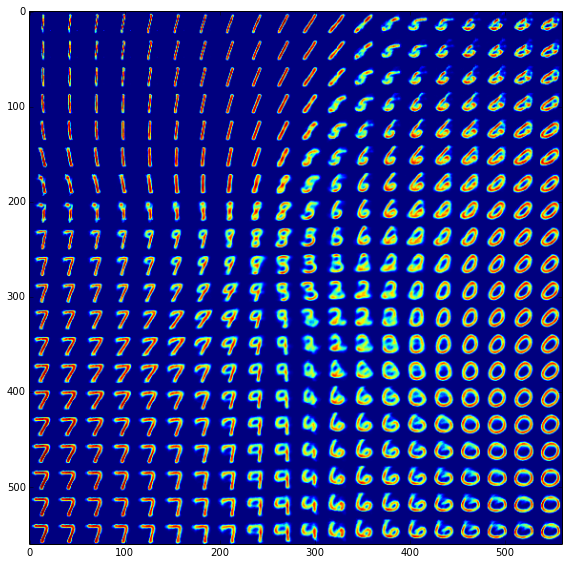

In [66]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]])
        x_mean = vae.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper")
plt.tight_layout()
plt.savefig('vis2.png',dpi=300)
 

In [18]:
run_test(50,1.0,'bernoulli',0,0, trial_num=0)

Epoch: 0001 cost= 178.325536111 latent count= 49
Epoch: 0011 cost= 104.283441883 latent count= 21
Epoch: 0021 cost= 99.930113387 latent count= 12
Epoch: 0031 cost= 98.424871771 latent count= 12
Epoch: 0041 cost= 97.337623402 latent count= 12
Epoch: 0051 cost= 96.528512504 latent count= 12
Epoch: 0061 cost= 96.092736026 latent count= 12
Epoch: 0071 cost= 95.706147544 latent count= 12
Epoch: 0081 cost= 95.197745209 latent count= 12
Epoch: 0091 cost= 94.765711614 latent count= 12
Epoch: 0101 cost= 94.518611603 latent count= 12
Epoch: 0111 cost= 94.350559248 latent count= 12
Epoch: 0121 cost= 93.964056521 latent count= 12
Epoch: 0131 cost= 93.667783203 latent count= 12
Epoch: 0141 cost= 93.666177174 latent count= 12
Epoch: 0151 cost= 93.328430204 latent count= 12
Epoch: 0161 cost= 93.290163699 latent count= 12
Epoch: 0171 cost= 93.092559121 latent count= 12
Epoch: 0181 cost= 93.000843298 latent count= 12
Epoch: 0191 cost= 92.900549150 latent count= 12
Epoch: 0201 cost= 92.860372301 latent 

KeyboardInterrupt: 

<module 'tensorflow' from '/Users/jesse/anaconda/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

In [32]:
run_test(50,1.0,'bernoulli',0,0)

Epoch: 0001 cost= 179.977577653 latent count= 50
Epoch: 0002 cost= 132.733644756 latent count= 46
Epoch: 0003 cost= 119.723101890 latent count= 40
Epoch: 0004 cost= 114.744074929 latent count= 35
Epoch: 0005 cost= 111.920076710 latent count= 22
Epoch: 0006 cost= 109.691122561 latent count= 24
Epoch: 0007 cost= 108.033894015 latent count= 27
Epoch: 0008 cost= 106.891289423 latent count= 20
Epoch: 0009 cost= 105.935705372 latent count= 16
Epoch: 0010 cost= 105.027928925 latent count= 13
Epoch: 0011 cost= 104.306511605 latent count= 12
Epoch: 0012 cost= 103.683468808 latent count= 11
Epoch: 0013 cost= 103.213347279 latent count= 11
Epoch: 0014 cost= 102.744676375 latent count= 11
Epoch: 0015 cost= 102.352309889 latent count= 11
Epoch: 0016 cost= 102.007521876 latent count= 11
Epoch: 0017 cost= 101.731481726 latent count= 11
Epoch: 0018 cost= 101.409188579 latent count= 11
Epoch: 0019 cost= 101.133571222 latent count= 11
Epoch: 0020 cost= 100.878429135 latent count= 11
Epoch: 0021 cost= 10

In [33]:
run_test(50,0.5,'bernoulli',0,0)

Epoch: 0001 cost= 203.890772455 latent count= 28
Epoch: 0002 cost= 180.334891801 latent count= 34
Epoch: 0003 cost= 154.076310674 latent count= 27
Epoch: 0004 cost= 142.518486134 latent count= 35
Epoch: 0005 cost= 137.119370894 latent count= 33
Epoch: 0006 cost= 132.881529652 latent count= 15
Epoch: 0007 cost= 129.645116036 latent count= 6
Epoch: 0008 cost= 127.817501554 latent count= 6
Epoch: 0009 cost= 126.787633709 latent count= 6
Epoch: 0010 cost= 125.830427191 latent count= 6
Epoch: 0011 cost= 125.090754783 latent count= 6
Epoch: 0012 cost= 124.425682706 latent count= 14
Epoch: 0013 cost= 123.842134899 latent count= 17
Epoch: 0014 cost= 123.250054682 latent count= 31
Epoch: 0015 cost= 122.666556868 latent count= 29
Epoch: 0016 cost= 122.093759266 latent count= 33
Epoch: 0017 cost= 121.535437178 latent count= 29
Epoch: 0018 cost= 121.150656433 latent count= 22
Epoch: 0019 cost= 120.667429615 latent count= 21
Epoch: 0020 cost= 120.197234386 latent count= 13
Epoch: 0021 cost= 119.758

In [43]:
run_test(50,1,'bernoulli',1,0)

Epoch: 0001 cost= 171.520026356 latent count= 50
Epoch: 0002 cost= 137.648983196 latent count= 50
Epoch: 0003 cost= 126.836473805 latent count= 50
Epoch: 0004 cost= 119.045734808 latent count= 50
Epoch: 0005 cost= 114.728330619 latent count= 48
Epoch: 0006 cost= 112.158465479 latent count= 37
Epoch: 0007 cost= 110.484685475 latent count= 34
Epoch: 0008 cost= 109.492429047 latent count= 31
Epoch: 0009 cost= 108.536700717 latent count= 35
Epoch: 0010 cost= 108.078433422 latent count= 30
Epoch: 0011 cost= 107.442292952 latent count= 26
Epoch: 0012 cost= 107.077959428 latent count= 28
Epoch: 0013 cost= 106.619538255 latent count= 27
Epoch: 0014 cost= 106.237012287 latent count= 27
Epoch: 0015 cost= 105.989169880 latent count= 26
Epoch: 0016 cost= 105.705297519 latent count= 25
Epoch: 0017 cost= 105.193785622 latent count= 20
Epoch: 0018 cost= 104.968549083 latent count= 25
Epoch: 0019 cost= 104.791058294 latent count= 21
Epoch: 0020 cost= 104.549718864 latent count= 21
Epoch: 0021 cost= 10

In [44]:
run_test(50,1,'bernoulli',1,1)

Epoch: 0001 cost= 172.547193271 latent count= 50
Epoch: 0002 cost= 138.534998169 latent count= 50
Epoch: 0003 cost= 127.295848555 latent count= 50
Epoch: 0004 cost= 119.653389310 latent count= 50
Epoch: 0005 cost= 115.095631409 latent count= 49
Epoch: 0006 cost= 112.107385684 latent count= 38
Epoch: 0007 cost= 110.695306244 latent count= 37
Epoch: 0008 cost= 109.568131464 latent count= 31
Epoch: 0009 cost= 108.691408234 latent count= 31
Epoch: 0010 cost= 107.773767589 latent count= 27
Epoch: 0011 cost= 107.397491275 latent count= 24
Epoch: 0012 cost= 106.799822332 latent count= 31
Epoch: 0013 cost= 106.625065238 latent count= 28
Epoch: 0014 cost= 106.110105230 latent count= 24
Epoch: 0015 cost= 105.769893993 latent count= 26
Epoch: 0016 cost= 105.474953322 latent count= 22
Epoch: 0017 cost= 105.121140067 latent count= 26
Epoch: 0018 cost= 104.889354512 latent count= 23
Epoch: 0019 cost= 104.804443415 latent count= 26
Epoch: 0020 cost= 104.563973430 latent count= 22
Epoch: 0021 cost= 10

In [45]:
run_test(50,1,'bernoulli',0,1)

Epoch: 0001 cost= 180.767084517 latent count= 50
Epoch: 0002 cost= 132.644286166 latent count= 49
Epoch: 0003 cost= 119.425628010 latent count= 44
Epoch: 0004 cost= 113.897559287 latent count= 22
Epoch: 0005 cost= 110.908188893 latent count= 16
Epoch: 0006 cost= 108.733438998 latent count= 17
Epoch: 0007 cost= 107.389956415 latent count= 26
Epoch: 0008 cost= 106.298301572 latent count= 31
Epoch: 0009 cost= 105.463210311 latent count= 29
Epoch: 0010 cost= 104.625549635 latent count= 29
Epoch: 0011 cost= 103.960606426 latent count= 29
Epoch: 0012 cost= 103.426303267 latent count= 30
Epoch: 0013 cost= 102.909362488 latent count= 29
Epoch: 0014 cost= 102.481234270 latent count= 28
Epoch: 0015 cost= 102.039173903 latent count= 22
Epoch: 0016 cost= 101.557719491 latent count= 16
Epoch: 0017 cost= 101.191277133 latent count= 12
Epoch: 0018 cost= 100.765564173 latent count= 12
Epoch: 0019 cost= 100.518774414 latent count= 12
Epoch: 0020 cost= 100.255971680 latent count= 12
Epoch: 0021 cost= 99